### Installing Dependencies

In [ ]:
!pip3 install torch==1.12.0
!pip3 install torchvision==0.13.0
!pip3 install numpy==1.21.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16

### Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/U-Net

/content/drive/MyDrive/Colab Notebooks/U-Net


### Importing Libraries

In [ ]:
import os
import argparse
import numpy as np
from skimage import io, transform
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import tifffile as tiff
from skimage.transform import resize
import torch
import torch.nn as nn
from torch import nn, optim, DoubleTensor
from torch import cuda
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms, datasets
#from unet import UNet
from celldata import CellDataset
from metric import iou, pix_acc
from loss import Weighted_Cross_Entropy_Loss
from augmentation import (
    DoubleCompose, DoubleToTensor,
    DoubleHorizontalFlip, DoubleVerticalFlip, DoubleElasticTransform,
    GaussianNoise
)



### Defining Variables

In [ ]:

pretrained_model_path='/content/drive/MyDrive/Colab Notebooks/U-Net/checkpoints'
data_dir='/content/drive/MyDrive/Colab Notebooks/U-Net/VNC'
epochs=50
lr=0.0001
batch_size=3
test_batch_size=3

## Defining UNet model

In [ ]:
class UNet(torch.nn.Module):

    def __init__(self, n_classes, batch_norm=True):
        """
        """
        self.name = 'UNet'
        self.n_classes = n_classes
        self.filter_sizes = [64, 128, 256, 512, 1024]
        self.n_block = len(self.filter_sizes)
        self.batch_norm = batch_norm
        # self.num_layers = [2, 2, 2, 2, 2]

        super(UNet, self).__init__()
        self.contract_blocks = self.contract()
        self.expand_blocks = self.expand()
        self.segment = nn.Conv2d(
            self.filter_sizes[0],
            self.n_classes,
            kernel_size=1
        )

    def forward(self, x):
        """Performs a forward pass through the network
        """
        xs = []
        for block in self.contract_blocks:
            new_x = block(x)
            xs.append(new_x)
            x = new_x

        for i, block in enumerate(self.expand_blocks):
            x = block['up'](x)
            k = self.n_block - i - 2
            x = self.concat(xs[k], x)
            x = block['conv'](x)

        y_pred = self.segment(x)

        return y_pred

    def concat(self, x, y):
        """Crop and concatenate two feature maps
        """
        dw = (x.size()[2] - y.size()[2]) // 2
        dh = (x.size()[3] - y.size()[2]) // 2
        x = x[:, :, dw:x.size()[2] - dw, dh:x.size()[3] - dh]
        return torch.cat((x, y), 1)

    def contract(self):
        """Define contraction block in U-Net
        """
        blocks = []
        old = 1
        for i, size in enumerate(self.filter_sizes):
            mpool = nn.MaxPool2d(kernel_size=2)
            conv1 = nn.Conv2d(old, size, kernel_size=3)
            conv2 = nn.Conv2d(size, size, kernel_size=3)
            relu = nn.ReLU(True)
            convs = [mpool, conv1, relu, conv2, relu]
            if self.batch_norm:
                b_norm = nn.BatchNorm2d(size)
                convs = [mpool, conv1, b_norm, relu, conv2, b_norm, relu]
            if i == 0:
                convs = convs[1:]
            block = nn.Sequential(*convs)
            blocks.append(block)
            old = size
            self.add_module(f'contract{i+1}', block)
        return blocks

    def expand(self):
        """Define expansion block in U-Net
        """
        blocks = []
        expand_filters = self.filter_sizes[self.n_block - 2::-1]
        old = self.filter_sizes[-1]
        for i, size in enumerate(expand_filters):
            up = nn.ConvTranspose2d(old, size, kernel_size=2, stride=2)
            self.add_module(f'up{i+1}', up)
            conv1 = nn.Conv2d(old, size, kernel_size=3)
            conv2 = nn.Conv2d(size, size, kernel_size=3)
            relu = nn.ReLU(True)
            convs = [conv1, relu, conv2, relu]
            if self.batch_norm:
                b_norm = nn.BatchNorm2d(size)
                convs = [conv1, b_norm, relu, conv2, b_norm, relu]
            convs = nn.Sequential(*convs)
            self.add_module(f'deconv{i+1}', convs)
            blocks.append({'up': up, 'conv': convs})

            old = size

        return blocks


### Downloading Pretrained Model

In [ ]:
if os.path.exists(pretrained_model_path) is False:
  print("Downloading pretrained model")
  os.makedirs(pretrained_model_path, exist_ok=True)
  !wget https://www.dropbox.com/s/mbwbv4k1kyjpz5f/UNet50.pt?dl=0 -O checkpoints/UNet50.pt
else:
  print('Already Downloaded')

Already Downloaded


### Downloading VNC Dataset

In [ ]:
if os.path.exists(data_dir) is False:
  print("Downloading Dataset")
  os.makedirs(data_dir, exist_ok=True)
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/test-volume.tif -O /content/drive/MyDrive/Colab Notebooks/VNC/test-volume.tif
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/train-labels.tif -O /content/drive/MyDrive/Colab Notebooks/VNC/train-labels.tif
  !wget https://github.com/hayashimasa/UNet-PyTorch/raw/main/data/train-volume.tif -O /content/drive/MyDrive/Colab Notebooks/VNC/train-volume.tif
else:
  print('Dataset Already Downloaded')

Dataset Already Downloaded


### visualizing Dataset

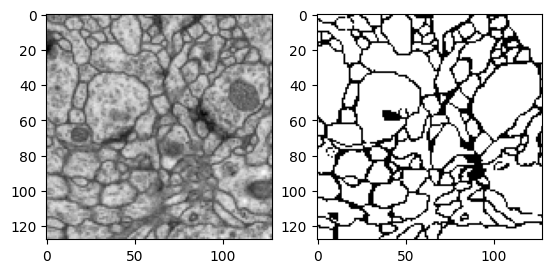

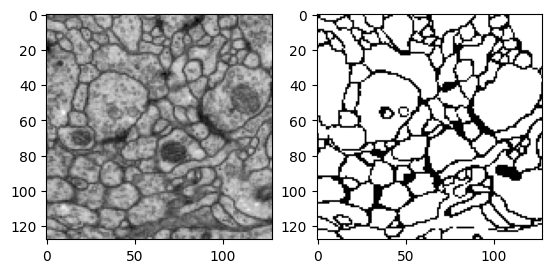

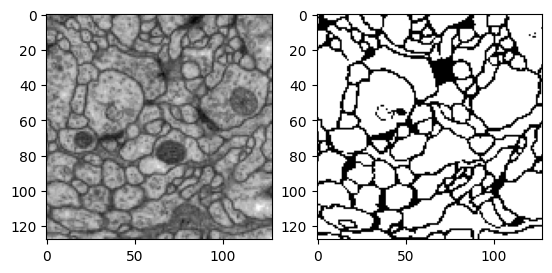

In [ ]:

img_trn = tiff.imread(data_dir+f'/train-volume.tif')
msk_trn = tiff.imread(data_dir+f'/train-labels.tif')

index=1
for img,msk in zip(img_trn, msk_trn):
    _img = resize(img, (128,128))
    _msk = resize(msk, (128,128)).round()
    fig,_ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].imshow(_img, cmap='gray')
    fig.axes[1].imshow(_msk, cmap='gray')
    plt.show()
    if(index==3):
      break
    index+=1


### Helper Functions for Loading Data and Training

In [ ]:
def get_train_loader(mean, std, out_size, batch_size, pct=.9):
    """Initialize Dataloader for training set

        mean (float): mean of pixel values
        std (float): standard deviation of pixel values
        out_size (int): dimension of segmentation map (out_size x out_size)
        batch_size (int): number of samples to load for each iteration
        pct (float): percentage of data to use for training (0 < pct <= 1)
    """
    image_mask_transform = DoubleCompose([
        DoubleToTensor(),
        DoubleElasticTransform(alpha=250, sigma=10),
        DoubleHorizontalFlip(),
        DoubleVerticalFlip()
    ])
    image_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.4),
        transforms.Normalize(mean, std),
        GaussianNoise(),
        transforms.Pad(30, padding_mode='reflect')
    ])
    mask_transform = transforms.CenterCrop(out_size)

    train_data = CellDataset(
        image_mask_transform=image_mask_transform,
        image_transform=image_transform,
        mask_transform=mask_transform,
        pct=pct
    )
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    return train_loader


def get_test_loader(mean, std, out_size, batch_size):
    """Initialize Dataloader for validation set

        mean (float): mean of pixel values
        std (float): standard deviation of pixel values
        out_size (int): dimension of segmentation map (out_size x out_size)
        batch_size (int): number of samples to load for each iteration
    """
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.Pad(30, padding_mode='reflect')
    ])
    mask_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(388)
    ])

    test_data = CellDataset(
        image_transform=image_transform,
        mask_transform=mask_transform,
        data_type='validate'
    )

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False
    )
    return test_loader


def train(model, device, data_loader, optimizer, criterion, epoch):
    """train model for one epoch

    """
    model.train()
    loss = 0.
    for step, sample in enumerate(data_loader):
        # forward pass
        X = sample['image'].to(device)
        y = sample['mask'].to(device)
        w = sample['weight'].to(device)
        y = y.squeeze(1).long()  # remove channel dimension
        y_pred = model(X)

        # back propogation
        loss = criterion(y_pred, y, w)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        log_interval = 1
        if step % log_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (step+1) * len(X), len(data_loader.dataset),
                    100. * (step+1) / len(data_loader), loss.item()
                )
            )
        # break

    return loss.item()


def validate(model, device, data_loader, criterion, n_classes):
    """Evaluate model performance with validation data

    """
    model.eval()
    test_loss = 0
    n = len(data_loader.dataset)
    class_iou = [0.] * n_classes
    pixel_acc = 0.
    with torch.no_grad():
        for sample in data_loader:
            X = sample['image'].to(device)
            y = sample['mask'].to(device)
            w = sample['weight'].to(device)
            y = y.squeeze(1).long()  # remove channel dimension
            y_pred = model(X)
            test_loss += criterion(y_pred, y, w).item()  # sum up batch loss
            pred = torch.argmax(y_pred, dim=1)
            batch_size = X.shape[0]
            pred = pred.view(batch_size, -1)
            y = y.view(batch_size, -1)
            batch_iou = iou(pred, y, batch_size, n_classes)
            class_iou += batch_iou * (batch_size / n)
            pixel_acc += pix_acc(pred, y, batch_size) * (batch_size / n)

    data_size = len(data_loader.dataset)
    test_loss /= data_size
    avg_iou = np.mean(class_iou)

    print(
        '\nValidation set: Average loss: {:.4f}, '.format(test_loss)
        + 'Average IOU score: {:.2f}, '.format(avg_iou)
        + 'Average pixel accuracy: {:.2f}\n'.format(pixel_acc)
    )
    return test_loss, avg_iou, pixel_acc


def initialize_model():
    """Initialize model checkpoint dictionary for storing training progress

    Args:
        args (object):
            epoch (int): total number of epochs to train model
            n_classes (int): number of segmentation classes
    """
    model_dict = {
        'total_epoch': epochs,
        'n_classes': 2,
        'model_state_dict': None,
        'optimizer_state_dict': None,
        'train_loss': list(),
        'test_loss': list(),
        'metrics': {
            'IOU': list(),
            'pix_acc': list(),
            'best': {
                'IOU': 0.,
                'pixel_acc': 0.,
                'epoch': 0
            }
        }
    }
    return model_dict


### Training

In [ ]:
def get_model(device):
    """Intialize or load model checkpoint and intialize model and optimizer

    """

    # Load model checkpoint
    model_dict = torch.load(pretrained_model_path+f'/UNet50.pt')
    # else:
    #     model_dict = initialize_model(args)
    n_classes = model_dict['n_classes']
    model = UNet(n_classes).cuda() if device == 'cuda' else UNet(n_classes)
    optimizer = optim.Adam(model.parameters(),lr)

    model.load_state_dict(model_dict['model_state_dict'])
    optimizer.load_state_dict(model_dict['optimizer_state_dict'])
    return model, optimizer, model_dict



    # args = parse_args()
    # if args.tensorboard:
writer = SummaryWriter()
# initialize model
device = (
    'cuda' if torch.cuda.is_available() else 'cpu'
)
model, optimizer, model_dict = get_model(device)
# initialize dataloader
mean = 0.495
std = 0.173
out_size = 388  # output dimension of segmentation map
train_loader = get_train_loader(mean, std, out_size, batch_size)
test_loader = get_test_loader(mean, std, out_size, test_batch_size)
# define loss function
criterion = Weighted_Cross_Entropy_Loss()
# train and evaluate model
start_epoch = 1

n_epoch = start_epoch + epochs - 1
model_path = pretrained_model_path
if not os.path.isdir(model_path):
    os.mkdir(model_path)
model_name =f'checkpoints/UNet{epochs}.pt'
for epoch in range(start_epoch, n_epoch + 1):
    train_loss = train(
        model, device, train_loader, optimizer, criterion, epoch
    )
    test_loss, test_iou, test_pix_acc = validate(
        model, device, test_loader, criterion, 2
    )
    # update tensorboard
    # if args.tensorboard:
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('IOU/test', test_iou, epoch)
    writer.add_scalar('Pixel_Accuracy/test', test_pix_acc, epoch)
    # record training progress
    model_dict['train_loss'].append(train_loss)
    model_dict['test_loss'].append(test_loss)
    model_dict['metrics']['IOU'].append(test_iou)
    model_dict['metrics']['pix_acc'].append(test_pix_acc)
    if epoch == 1 or test_iou > model_dict['metrics']['best']['IOU']:
        model_dict['model_state_dict'] = model.state_dict()
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
        model_dict['metrics']['best']['IOU'] = test_iou
        model_dict['metrics']['best']['pix_acc'] = test_pix_acc
        model_dict['metrics']['best']['epoch'] = epoch
    # if args.save:
    torch.save(model_dict, model_name)
# if args.tensorboard:
writer.close()
print('Best IOU:', model_dict['metrics']['best']['IOU'])
print('Pixel accuracy:', model_dict['metrics']['best']['pix_acc'])


Train Epoch: 1 [3/27 (11%)]	Loss: 0.131348
Train Epoch: 1 [6/27 (22%)]	Loss: 0.127414
Train Epoch: 1 [9/27 (33%)]	Loss: 0.129450
Train Epoch: 1 [12/27 (44%)]	Loss: 0.107806
Train Epoch: 1 [15/27 (56%)]	Loss: 0.092803
Train Epoch: 1 [18/27 (67%)]	Loss: 0.088653
Train Epoch: 1 [21/27 (78%)]	Loss: 0.130518
Train Epoch: 1 [24/27 (89%)]	Loss: 0.164445
Train Epoch: 1 [27/27 (100%)]	Loss: 0.125365

Validation set: Average loss: 0.1024, Average IOU score: 0.65, Average pixel accuracy: 0.88

Train Epoch: 2 [3/27 (11%)]	Loss: 0.103924
Train Epoch: 2 [6/27 (22%)]	Loss: 0.129773
Train Epoch: 2 [9/27 (33%)]	Loss: 0.113264
Train Epoch: 2 [12/27 (44%)]	Loss: 0.152731
Train Epoch: 2 [15/27 (56%)]	Loss: 0.094444
Train Epoch: 2 [18/27 (67%)]	Loss: 0.150440
Train Epoch: 2 [21/27 (78%)]	Loss: 0.137966
Train Epoch: 2 [24/27 (89%)]	Loss: 0.146027
Train Epoch: 2 [27/27 (100%)]	Loss: 0.088294

Validation set: Average loss: 0.1628, Average IOU score: 0.64, Average pixel accuracy: 0.82

Train Epoch: 3 [3/27 (11

### Inference

/content/drive/MyDrive/Colab Notebooks/U-Net/checkpoints/UNet50.pt


<Figure size 2000x2000 with 0 Axes>

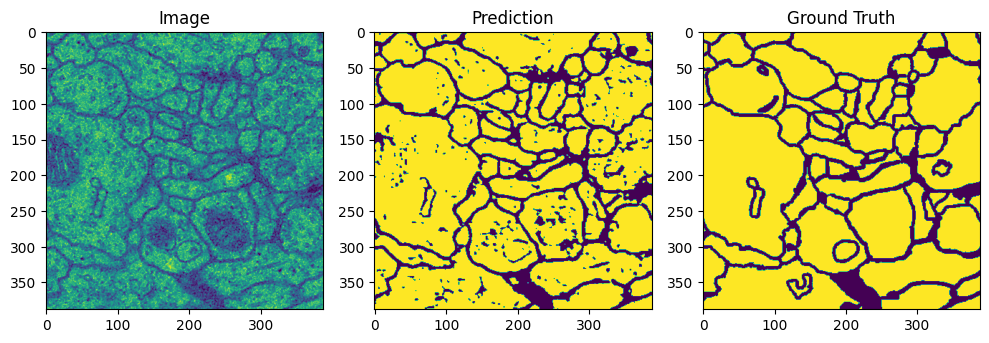

/content/drive/MyDrive/Colab Notebooks/U-Net/checkpoints/UNet50.pt


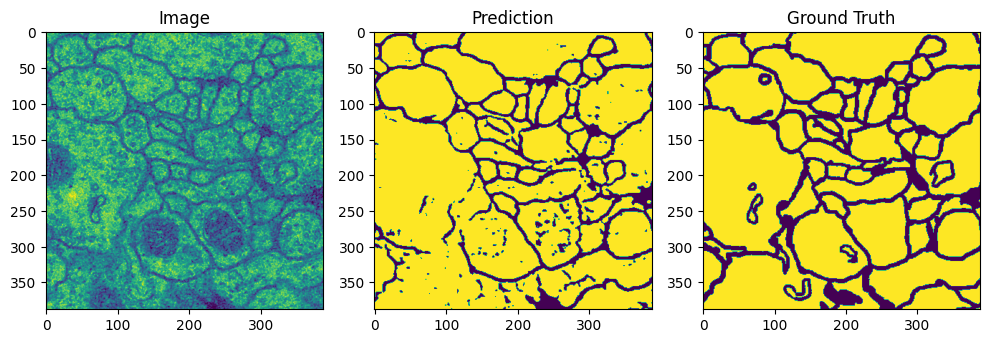

/content/drive/MyDrive/Colab Notebooks/U-Net/checkpoints/UNet50.pt


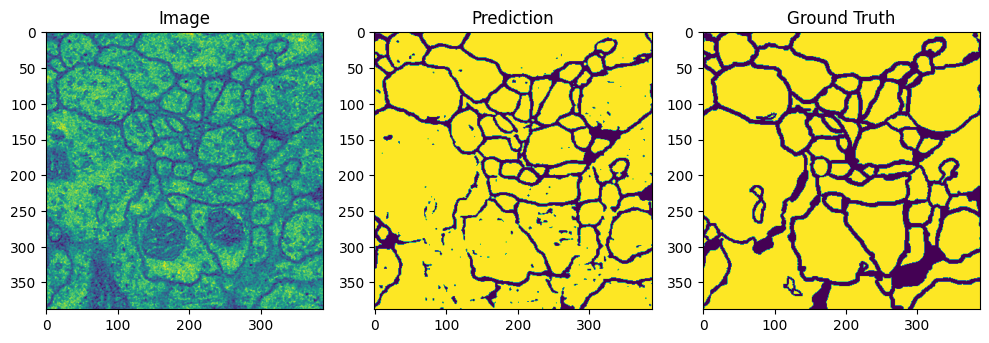

/content/drive/MyDrive/Colab Notebooks/U-Net/checkpoints/UNet50.pt


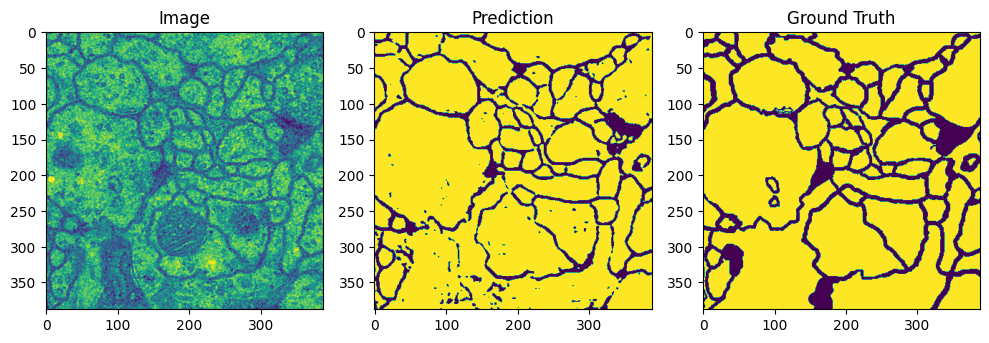

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(20,20))

def predict(image, model):
    """Make prediction on image"""
    mean = 0.495
    std = 0.173
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.Pad(30, padding_mode='reflect')
    ])
    im = image_transform(image)
    im = im.view(1, *im.shape)
    model.eval()
    y_pred = model(im)
    pred = torch.argmax(y_pred, dim=1)[0]
    return pred

def visualize(image, pred, label=None):
    """make visualization"""
    n_plot = 2 if label is None else 3
    fig = plt.figure()
    ax = fig.add_subplot(1, n_plot, 1)
    imgplot = plt.imshow(image)
    ax.set_title('Image')
    ax = fig.add_subplot(1, n_plot, 2)
    imgplot = plt.imshow(pred)
    ax.set_title('Prediction')
    if n_plot > 2:
        ax = fig.add_subplot(1, n_plot, 3)
        imgplot = plt.imshow(label)
        ax.set_title('Ground Truth')
    fig.tight_layout()

    plt.show()



for i in range(2,6):
    images = io.imread(data_dir+f'/train-volume.tif')
    labels = io.imread(data_dir+f'/train-labels.tif')
    image = images[-i]
    label = labels[-i]

    # load model
    print(pretrained_model_path+f'/UNet50.pt')
    checkpoint = torch.load(pretrained_model_path+f'/UNet50.pt', map_location=torch.device('cpu'))
    model = UNet(2)
    model.load_state_dict(checkpoint['model_state_dict'])
    # make inference
    pred = predict(image, model)

    # if args.visualize:
        # crop images for visualization
    dim = image.shape
    out_size = pred.shape[0]
    cut = (dim[0] - out_size) // 2
    image = image[cut:cut+out_size, cut:cut+out_size]
    label = label[cut:cut+out_size, cut:cut+out_size]
    # visualize result
    visualize(image, pred, label)


